# DTSA - 5511 Deeplearning - Final Project Kaggle Challenge
## PlantTraits2024 - FGVC11
Uncovering the biosphere: Predicting 6 Vital Plant Traits from Plant Images for Ecosystem Health

Kaggle Link: https://www.kaggle.com/competitions/planttraits2024/overview

The objective of this project is to classify the open-sourced plant images into 6 plant traits (such as leaf area, plant height etc). In addition to the image data, the project also provides related data (based on geo-location of the images) such as Climate, Soil and Sattelite data.

#### From the Kaggle Project description

This competition aims to predict plant properties - so called plant traits - from citizen science plant photographs. Why are plant traits currently so relevant? Plant traits are plant properties that are used to describe how plants function how they interact with the environment. For instance, the trait of plant canopy height indicates how good a plant is at overshadowing its neightbors in the competition for sun light. Robust leaves (indicated by the leaf mass pear leaf area) indicate that plants optimize towards extreme conditions, such as heavy winds or droughts. Yet, environmental conditions are not static. Due to global change, the biosphere is being transformed at accelerating pace. Especially climate change is assumed to drastically impact the functioning of the ecosystems. This includes several processes, e.g. adaptions of plants and their traits to new conditions or even a altered plant species distribution with a resulting modification of the distribution of plant traits. However, we can hardly project on a global scale how plant traits and as such entire ecosystems will react to climate change because we do not have sufficient data on plant traits.

A data treasure in this regard may be the growing availability of citizen science photographs. Thousands of citizens around the globe photograph plants with species identification apps (examples are iNaturalist or Pl@ntNet). The species are identified using AI algorithms, and the prediction, photograph, and geolocation are curated in open databases. There are already more than 20 million plant photographs available, covering all ecosystem types and continents.

## Dataset Description

**Files**:

- `train_images` - The folder with the training images (.jpeg)

- `train.csv` - The labels and the ancillary data (satellite data, soil data, climate data etc.) for each training image

- `test_images` - The folder with the test images (.jpeg) that shall be used to create the predictions for the submission.

- `test.csv` - The ancillary data (satellite data, soil data, climate data etc.) for each test image

- `target_name_meta.csv` - full names of the traits obtained from the TRY database. This is important to understand what all traits are we predicting

- `sample_submission.csv` - a sample submission file in the correct format



## Get the data  
Copy and Unzip files from Google drive
The zip data file was earlier copied from the Kaggle project `planttraits2024` dataset to my personal google drive.

[Instructions on using the Kaggle API can be found here](https://towardsdatascience.com/downloading-kaggle-datasets-directly-into-google-colab-c8f0f407d73a)

In [3]:
# Complete path to storage location of the .zip file of data
# Mount google drive
import os
from google.colab import drive
drive.mount('/gdrive',force_remount=True)

zip_path = '/gdrive/MyDrive/kaggle/planttraits2024.zip'
# Check current directory (be sure you're in the directory where Colab operates: '/content')
print(os.getcwd())
# Copy the .zip file into the present directory
!cp '{zip_path}' .
# Unzip quietly
!unzip -q 'planttraits2024.zip'
# View the unzipped contents in the virtual machine
os.listdir()

Mounted at /gdrive
/content


['.config',
 'train_images',
 'test.csv',
 'planttraits2024.zip',
 'target_name_meta.tsv',
 'train.csv',
 'sample_submission.csv',
 'test_images',
 'sample_data']

**Import all required libraries**

In [4]:
!pip install -q keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input, Concatenate
import keras
from tensorflow.keras import layers

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as k
import keras.utils as image
print(tf.__version__)
print(keras.__version__)

2.15.0
2.15.0


In [5]:
import os
os.listdir()

['.config',
 'train_images',
 'test.csv',
 'planttraits2024.zip',
 'target_name_meta.tsv',
 'train.csv',
 'sample_submission.csv',
 'test_images',
 'sample_data']

## Exploratory Data Analysis

### Read the Training labels and anciliary data file
This is a csv file with the image ID,  ancilliary data(climate, soil, satellite etc.) and the label.

*Note: The image files are .jpeg files with the image ID as their name*

In [6]:
train = pd.read_csv('./train.csv')
print(train.shape)

(55489, 176)


In [7]:
train.head()

id  WORLDCLIM_BIO1_annual_mean_temperature  \
0  192027691                               12.235703   
1  195542235                               17.270555   
2  196639184                               14.254504   
3  195728812                               18.680834   
4  195251545                                0.673204   

   WORLDCLIM_BIO12_annual_precipitation  \
0                            374.466675   
1                             90.239998   
2                            902.071411   
3                           1473.933350   
4                            530.088867   

   WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month  \
0                                          62.524445                       
1                                          10.351111                       
2                                          49.642857                       
3                                         163.100006                       
4                                          50.857777                       

   WORLDCLIM_BIO15_precipitation_seasonality  \
0                                  72.256844   
1                                  38.220940   
2                                  17.873655   
3                                  45.009758   
4                                  38.230709   

   WORLDCLIM_BIO4_temperature_seasonality  \
0                              773.592041   
1                              859.193298   
2                              387.977753   
3                              381.053986   
4                             1323.526855   

   WORLDCLIM_BIO7_temperature_annual_range  SOIL_bdod_0.5cm_mean_0.01_deg  \
0                                33.277779                            125   
1                                40.009777                            124   
2                                22.807142                            107   
3                                20.436666                            120   
4                                45.891998                             91   

   SOIL_bdod_100.200cm_mean_0.01_deg  SOIL_bdod_15.30cm_mean_0.01_deg  ...  \
0                                149                              136  ...   
1                                144                              138  ...   
2                                133                              119  ...   
3                                131                              125  ...   
4                                146                              120  ...   

   X18_mean   X26_mean  X50_mean   X3112_mean     X4_sd    X11_sd    X18_sd  \
0  0.117484   1.243779  1.849375    50.216034  0.008921  1.601473  0.025441   
1  0.389315   0.642940  1.353468   574.098472  0.003102  0.258078  0.000866   
2  8.552908   0.395241  2.343153  1130.096731       NaN       NaN       NaN   
3  1.083629   0.154200  1.155308  1042.686546  0.011692  2.818356  0.110673   
4  0.657585  10.919966  2.246226  2386.467180  0.006157  1.128000  0.026996   

     X26_sd    X50_sd    X3112_sd  
0  0.153608  0.279610   15.045054  
1  0.034630  0.010165   11.004477  
2       NaN       NaN         NaN  
3  0.011334  0.229224  141.857187  
4  0.553815  0.107092   87.146899  

[5 rows x 176 columns]

**Read the metadata file for label names**

In [8]:
label_names = pd.read_table('./target_name_meta.tsv')
pd.set_option('display.max_colwidth', None)
label_names

trait_ID  \
0       X4   
1      X11   
2      X18   
3      X26   
4      X50   
5    X3112   

                                                                           trait_name   
0   Stem specific density (SSD) or wood density (stem dry mass per stem fresh volume)   
1                      Leaf area per leaf dry mass (specific leaf area, SLA or 1/LMA)   
2                                                                        Plant height   
3                                                                       Seed dry mass   
4                                             Leaf nitrogen (N) content per leaf area   
5  Leaf area (in case of compound leaves: leaf, undefined if petiole in- or excluded)

**Get the label names from the target names metadata file**

The labels are given as mean values with their corresponding standard deviation.

In [9]:
class_names = list(label_names.trait_ID.astype('str')+'_mean')
print(class_names)
aux_class_names = list(map(lambda x: x.replace("mean","sd"), class_names))
print(aux_class_names)
num_classes = len(class_names)
num_classes_aux = len(aux_class_names)

['X4_mean', 'X11_mean', 'X18_mean', 'X26_mean', 'X50_mean', 'X3112_mean']
['X4_sd', 'X11_sd', 'X18_sd', 'X26_sd', 'X50_sd', 'X3112_sd']


**Check the target columns values**

In [10]:
train[class_names].describe()

X4_mean      X11_mean      X18_mean      X26_mean       X50_mean  \
count  55489.000000  5.548900e+04  5.548900e+04  5.548900e+04   55489.000000   
mean       0.522575  1.325267e+02  1.969902e+04  3.459399e+03      13.528574   
std        0.174853  1.278220e+04  2.309747e+06  2.471919e+05    1356.480785   
min       -2.431157  6.780000e-05  2.330000e-08  5.500000e-07       0.000097   
25%        0.410995  1.063987e+01  3.102831e-01  5.613414e-01       1.173489   
50%        0.509009  1.511232e+01  7.156651e-01  2.519985e+00       1.480060   
75%        0.622383  1.968160e+01  3.586311e+00  1.491886e+01       1.926343   
max        4.475172  1.504254e+06  2.720494e+08  3.106555e+07  159759.897700   

         X3112_mean  
count  5.548900e+04  
mean   3.975552e+05  
std    9.152463e+07  
min    7.690000e-08  
25%    2.552815e+02  
50%    7.244318e+02  
75%    2.148630e+03  
max    2.155911e+10

In [11]:
train[aux_class_names].describe()

X4_sd        X11_sd        X18_sd         X26_sd        X50_sd  \
count  39148.000000  39148.000000  39148.000000   39148.000000  39148.000000   
mean       0.007833      1.073573     16.003476     110.733150      0.075108   
std        0.012046      4.098486    881.605417    8361.855750      0.159520   
min        0.000000      0.000000      0.000000       0.000000      0.000000   
25%        0.003292      0.174866      0.029985       0.042226      0.017207   
50%        0.004996      0.357821      0.095136       0.238664      0.033162   
75%        0.007774      1.092862      0.330147       1.516574      0.082851   
max        0.284052    515.672017  63535.386846  739701.798818      9.729029   

            X3112_sd  
count   39148.000000  
mean      453.017146  
std      4196.228211  
min         0.000000  
25%        17.259899  
50%        63.322952  
75%       226.990400  
max    387491.201058

**Append `.jpeg` to image ID to get image filename**

In [12]:
train['image_id'] = train.id.astype(str) + '.jpeg'

In [13]:
train.set_index('id',drop=True,inplace=True)
train.head()

WORLDCLIM_BIO1_annual_mean_temperature  \
id                                                  
192027691                               12.235703   
195542235                               17.270555   
196639184                               14.254504   
195728812                               18.680834   
195251545                                0.673204   

           WORLDCLIM_BIO12_annual_precipitation  \
id                                                
192027691                            374.466675   
195542235                             90.239998   
196639184                            902.071411   
195728812                           1473.933350   
195251545                            530.088867   

           WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month  \
id                                                                                 
192027691                                                              62.524445   
195542235                                                              10.351111   
196639184                                                              49.642857   
195728812                                                             163.100006   
195251545                                                              50.857777   

           WORLDCLIM_BIO15_precipitation_seasonality  \
id                                                     
192027691                                  72.256844   
195542235                                  38.220940   
196639184                                  17.873655   
195728812                                  45.009758   
195251545                                  38.230709   

           WORLDCLIM_BIO4_temperature_seasonality  \
id                                                  
192027691                              773.592041   
195542235                              859.193298   
196639184                              387.977753   
195728812                              381.053986   
195251545                             1323.526855   

           WORLDCLIM_BIO7_temperature_annual_range  \
id                                                   
192027691                                33.277779   
195542235                                40.009777   
196639184                                22.807142   
195728812                                20.436666   
195251545                                45.891998   

           SOIL_bdod_0.5cm_mean_0.01_deg  SOIL_bdod_100.200cm_mean_0.01_deg  \
id                                                                            
192027691                            125                                149   
195542235                            124                                144   
196639184                            107                                133   
195728812                            120                                131   
195251545                             91                                146   

           SOIL_bdod_15.30cm_mean_0.01_deg  SOIL_bdod_30.60cm_mean_0.01_deg  \
id                                                                            
192027691                              136                              145   
195542235                              138                              143   
196639184                              119                              126   
195728812                              125                              131   
195251545                              120                              138   

           ...   X26_mean  X50_mean   X3112_mean     X4_sd    X11_sd  \
id         ...                                                         
192027691  ...   1.243779  1.849375    50.216034  0.008921  1.601473   
195542235  ...   0.642940  1.353468   574.098472  0.003102  0.258078   
196639184  ...   0.395241  2.343153  1130.096731       NaN       NaN   
195728812  ...   0.154200  1.155308  1042.686546  0.011692  2.818356   
19525154

**Replace missing values with zeroes in the target std deviation columns**

In [14]:
train[aux_class_names] = train[aux_class_names].fillna(0)
train[aux_class_names].head()

X4_sd    X11_sd    X18_sd    X26_sd    X50_sd    X3112_sd
id                                                                     
192027691  0.008921  1.601473  0.025441  0.153608  0.279610   15.045054
195542235  0.003102  0.258078  0.000866  0.034630  0.010165   11.004477
196639184  0.000000  0.000000  0.000000  0.000000  0.000000    0.000000
195728812  0.011692  2.818356  0.110673  0.011334  0.229224  141.857187
195251545  0.006157  1.128000  0.026996  0.553815  0.107092   87.146899

**Check if image_id matches the number of files in the train_images folder**

In [15]:
#train.image_id.head()
print(train['image_id'].count())
print(len(os.listdir('./train_images')))

55489
55489


**Extract some sample images from the training set**

We will also display the label values for each image

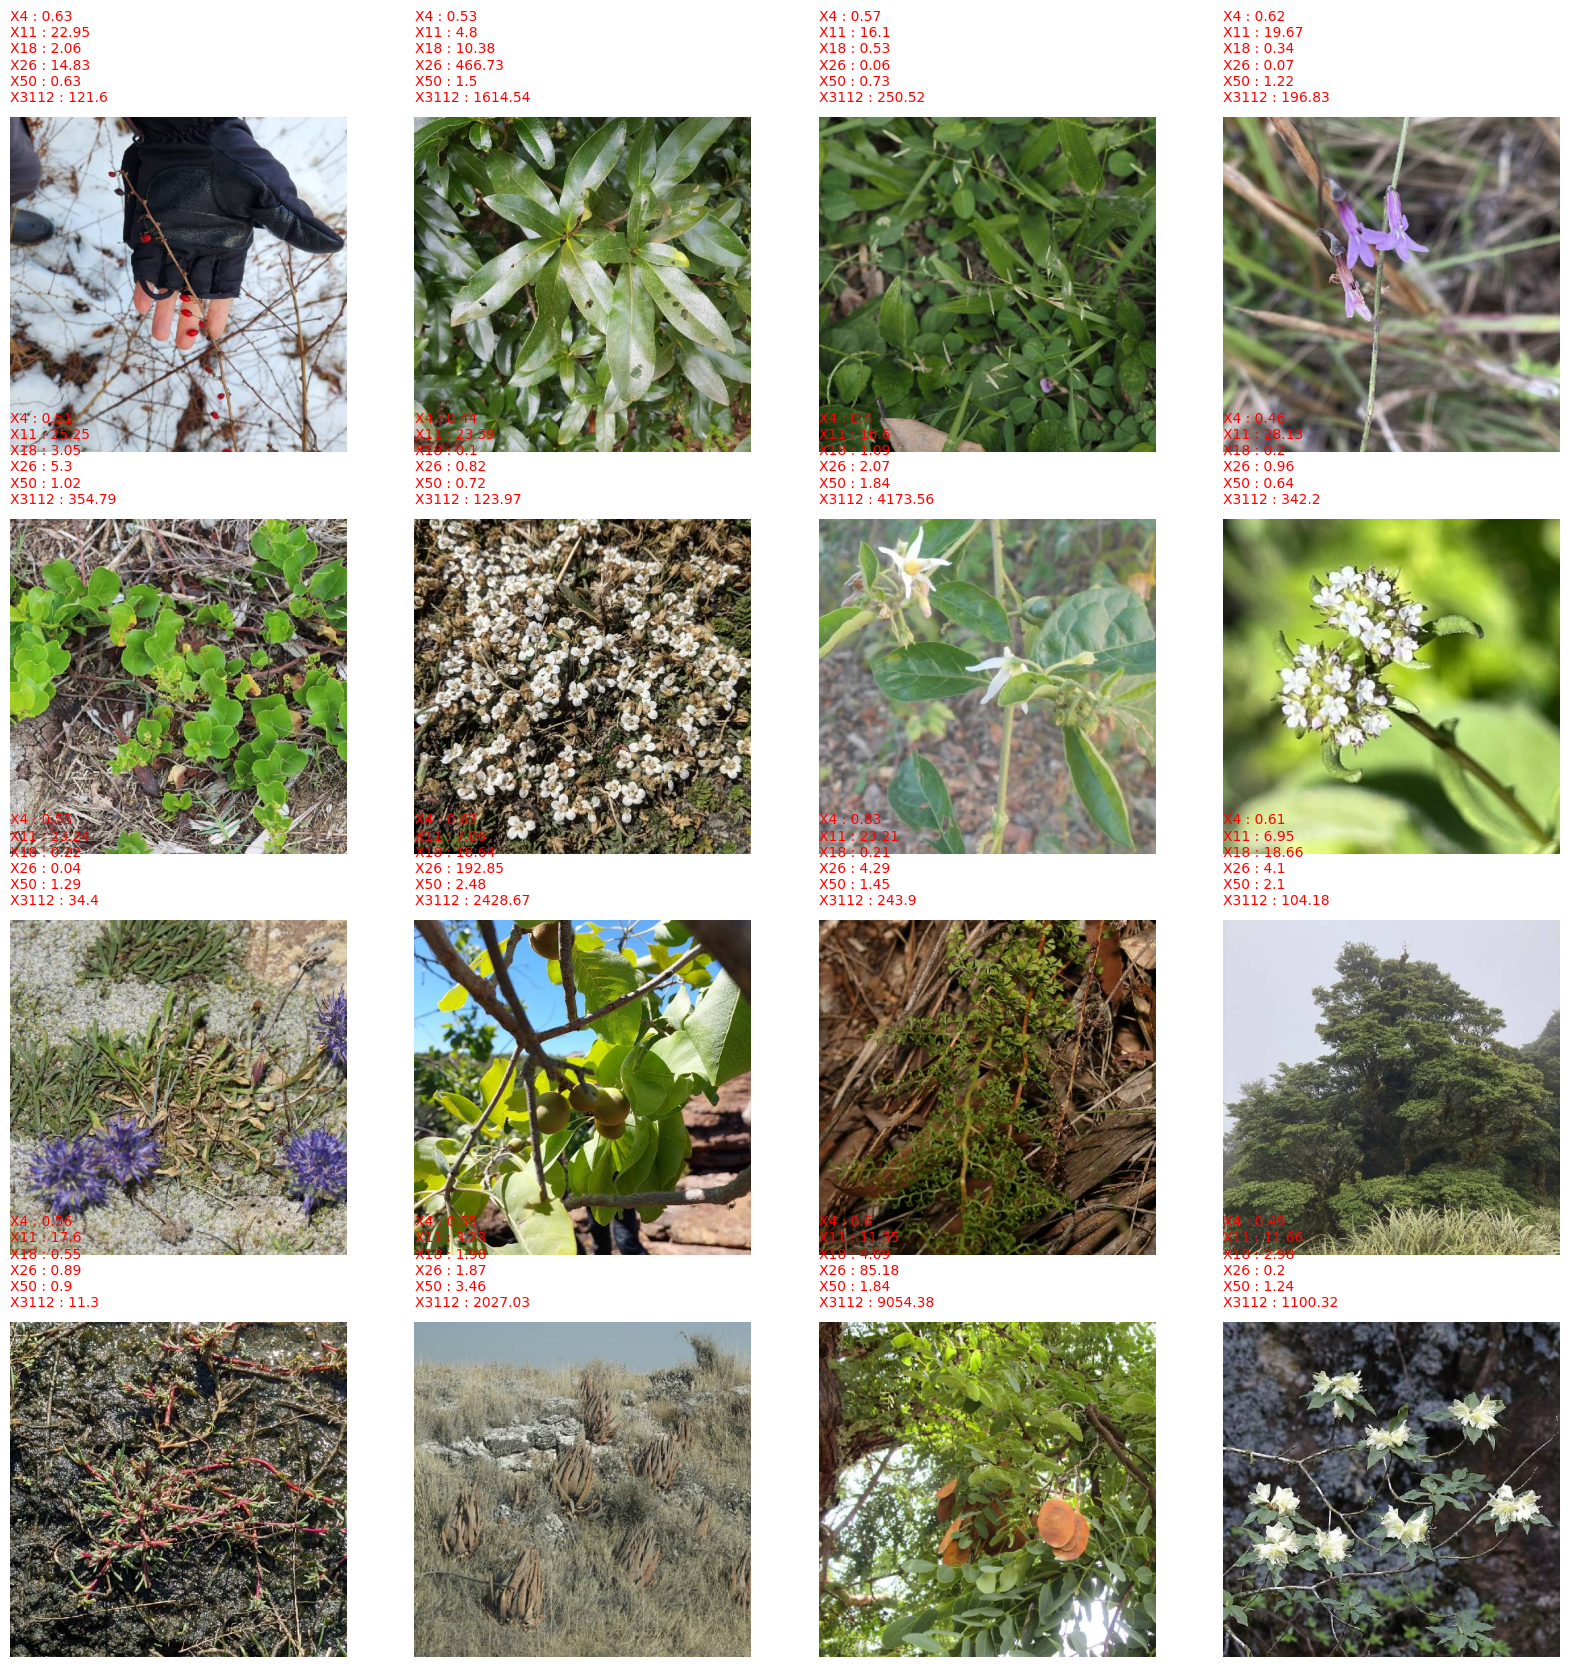

In [16]:
train_path = "./train_images"

sample = train.sample(n=16).reset_index()
fig = plt.figure(figsize=(20, 20))
for i, row in sample.iterrows():
    ax = fig.add_subplot(4, 4, i+1)
    img = mpimg.imread(f'{train_path}/{row.image_id}')
    ax.axis('off')
    disp = ''
    for label in class_names:
        val = np.round(float(row[label]),2).astype(str)
        disp += label.split('_')[0] + ' : ' + val + '\n'
    ax.axes.text(ax.axes.get_xlim()[0], ax.axes.get_ylim()[1], disp, color='red')
    ax.imshow(img, aspect='auto')
#plt.tight_layout()
plt.show()

##Prepare the training and validation data##
**Normalize the auxilliary columns in the training data**


In [17]:
for col in class_names:
    print(f"{col} mean = {train[col].mean(): .2f} std = {train[col].std(): .2f}")

X4_mean mean =  0.52 std =  0.17
X11_mean mean =  132.53 std =  12782.20
X18_mean mean =  19699.02 std =  2309746.82
X26_mean mean =  3459.40 std =  247191.90
X50_mean mean =  13.53 std =  1356.48
X3112_mean mean =  397555.22 std =  91524633.45


As is evident from above, the variation in a target label data is huge, therefore it does not make sense to normalize these columns

We will therefore only normalize the auxilliary tabular data that is provided before feeding into our model

We will also remove outliers (outside of 0.99 and 0.01 quantiles) from the training data

In [18]:
upper_quantile = []
for col in class_names:
    #print(train_df[[col]].describe())
    upper_quantile = train[[col]].quantile(0.99,interpolation='nearest')
    lower_quantile = train[[col]].quantile(0.01,interpolation='nearest')
    #print(upper_quantile)
    #print(lower_quantile)
    train = train[train[col] < upper_quantile[0]]
    train = train[train[col] > lower_quantile[0]]
print(train.shape)

(49133, 176)


In [19]:
#train_mean = {}
#train_std = {}
#for col in class_names:
#    train_mean[col] = train[col].mean()
#    train_std[col] = train[col].std()
#    train[col] = (train[col] - train_mean[col]) / train_std[col]
### Normalize the auxilliary input data
aux_train = train.drop(columns=class_names+aux_class_names+['image_id'])
aux_cols = aux_train.columns.tolist()
train[aux_cols] = train[aux_cols].apply(lambda x: (x - x.mean()) / (x.std()))
train[aux_cols].head()

WORLDCLIM_BIO1_annual_mean_temperature  \
id                                                  
192027691                               -0.303160   
195542235                                0.364697   
196639184                               -0.035372   
195728812                                0.551766   
195251545                               -1.836888   

           WORLDCLIM_BIO12_annual_precipitation  \
id                                                
192027691                             -0.885921   
195542235                             -1.263371   
196639184                             -0.185267   
195728812                              0.574159   
195251545                             -0.679256   

           WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month  \
id                                                                                 
192027691                                                              -0.557993   
195542235                                                              -0.951373   
196639184                                                              -0.655119   
195728812                                                               0.200334   
195251545                                                              -0.645958   

           WORLDCLIM_BIO15_precipitation_seasonality  \
id                                                     
192027691                                   0.474186   
195542235                                  -0.594375   
196639184                                  -1.233180   
195728812                                  -0.381239   
195251545                                  -0.594068   

           WORLDCLIM_BIO4_temperature_seasonality  \
id                                                  
192027691                                0.786839   
195542235                                1.056701   
196639184                               -0.428827   
195728812                               -0.450655   
195251545                                2.520534   

           WORLDCLIM_BIO7_temperature_annual_range  \
id                                                   
192027691                                 0.859860   
195542235                                 1.595644   
196639184                                -0.284543   
195728812                                -0.543628   
195251545                                 2.238550   

           SOIL_bdod_0.5cm_mean_0.01_deg  SOIL_bdod_100.200cm_mean_0.01_deg  \
id                                                                            
192027691                       0.441786                           0.564421   
195542235                       0.385035                           0.231496   
196639184                      -0.579731                          -0.500941   
195728812                       0.158031                          -0.634111   
195251545                      -1.487747                           0.364666   

           SOIL_bdod_15.30cm_mean_0.01_deg  SOIL_bdod_30.60cm_mean_0.01_deg  \
id                                                                            
192027691                         0.469278                         0.618042   
195542235                         0.594146                         0.489587   
196639184                        -0.592101                        -0.602278   
195728812                        -0.217497                        -0.281141   
195251545                        -0.529667                         0.168450   

           ...  VOD_X_1997_2018_multiyear_mean_m03  \
id         ...                                       
192027691  ...                            0.645448   
195542235  ...                           -0.769799   
196639184  ...                            0.494850   
195728812  ...                           -0.319868   
195251545  ...                           -0.126464   

           VOD_X_1997_2018_multiyear_mean_m04  \
id          

**Split training set into train and validation sets (80/20)**

In [20]:
### Split the training dataset into train and valid datasets
train_df, valid_df = train_test_split(train, test_size=0.2, random_state=1)

**Check the shapes of the training and validation sets**

In [21]:
print(train_df.shape)
print(valid_df.shape)
#valid_df.head()

(39306, 176)
(9827, 176)


#### Display the distribution of the train and valid label values

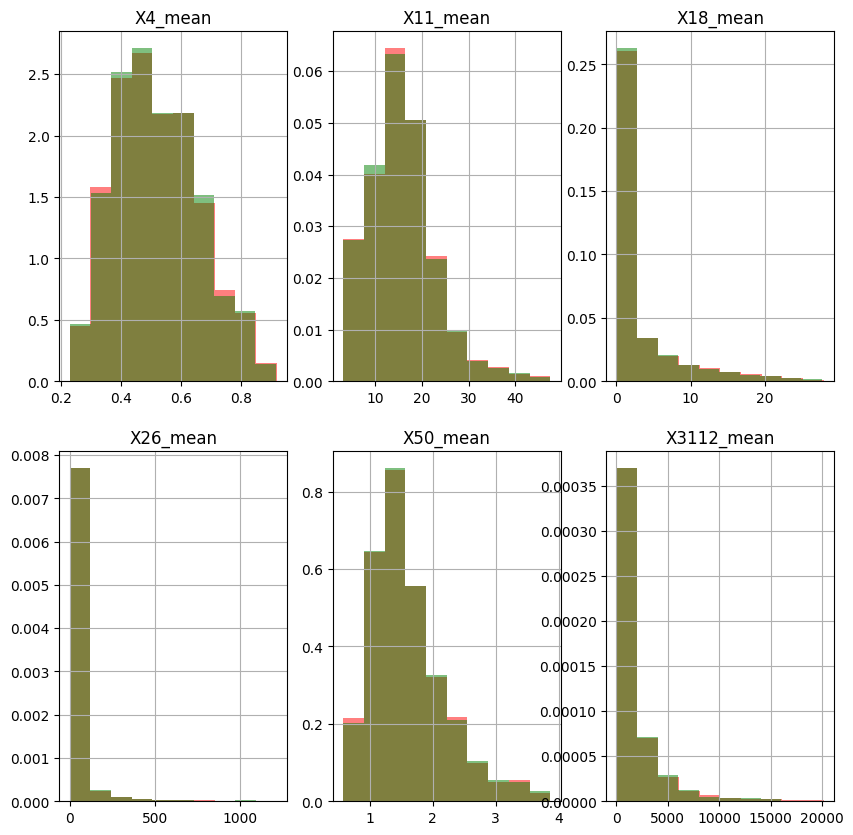

In [22]:
fig, axs = plt.subplots(2,3,figsize=(10, 10))
for i, ax in enumerate(axs.flat):
    #ax.axes.hist(train_df[class_names[i]])
    #ax.axis('off')
    col = class_names[i]
#    train_df[col] = train_df[class_names[i]].astype(float).apply(lambda x: np.log(x))
#    valid_df[col] = valid_df[class_names[i]].astype(float).apply(lambda x: np.log(x))
#    col_sd = aux_class_names[i]
#    train_df[col_sd] = train_df[col_sd].astype(float).apply(lambda x: np.log(x))
#    valid_df[col_sd] = valid_df[col_sd].astype(float).apply(lambda x: np.log(x))

    train_df[col].hist(ax=ax,density=True,bins=10,color='red', alpha=0.5)
    valid_df[col].hist(ax=ax,density=True,bins=10,color='green', alpha=0.5)
    ax.set_title(col)
#plt.tight_layout()
plt.show()

X18, X26 and X3112 could use logarithmic values to get a better distribution of the data. For now we will proceed with the normalized raw values and later revisit the above 3 trait values

### Generate image data using keras image library function ImageDataGenerator

We will use the built-in image processing library from Keras to process all the images from the train_images and valid_images directories

## Build the model
---




#### Define the model

The input data has two parts:
1. Image data in jpeg files in the train_images directory
2. Auxiliary data such as climate, satellite etc

The problem given is a multi-target regression problem with the above 2 sets of data as input and the plant traits mean values as targets.

To solve this problem we will:
1. Use Convolutional Neural network (CNN) to derive the image features from the input plant images

2. Next we will use the provided auxilliary data and pass thru a Dense layer

3. Finally we will concatenate the image features and the auxilliary data and feed it into a linear regression model to produce the output values.



For processing the images CNN architecture will have the following layers:


1.   3 sets of Convolution 2D layers with 32, 64 and 96 filters in each layer
2.   Each set of Conv2D layers is following by a layer of  Max Pooling
3.   Flatten the output into a 2 dimensional matrix
4.   Drop 20% of the parameters

For processing the auxilliary tabular data we will add the following layers:
1. Input layer with dimension same as the auxilliary columns
2. Dense layer with 128 parameters
3. Dropout layer of 20% drop

Combining the output features from the image data and the tabular data:
1. Run thru a Dense layer on the concatenated layers
2. Finally we will add a Dense layer with an activation function of `linear` to produce the regression output

Compile the model using the two inputs described above and the combined linear regression output

The loss function we will use is `cosine_similarity` as it is useful to compare the distance between the predicted and provided target vectors


In [54]:
np.random.seed(1)
tf.random.set_seed(1)
#### Image data layers
image_model = Sequential()
image_model.add(layers.Input(shape=(96,96,3), name='image_input'))
image_model.add(Conv2D(32, kernel_size=(3,3)))
image_model.add(MaxPooling2D(pool_size=(2,2)))
image_model.add(Conv2D(64, kernel_size=(3,3)))
image_model.add(MaxPooling2D(pool_size=(2,2)))
image_model.add(Conv2D(96, kernel_size=(3,3)))
image_model.add(MaxPooling2D(pool_size=(2,2)))
image_model.add(Flatten())
image_model.add(Dropout(0.2))
image_input = image_model.inputs
image_features = image_model.output
### Auxilliary data layers
aux_model = Sequential()
aux_model.add(layers.Input(shape=(len(aux_cols),), name='aux_input'))
aux_model.add(Dense(128,activation='relu'))
aux_model.add(Dropout(0.2))
aux_input = aux_model.inputs
aux_features = aux_model.output

### combine the image and auxilliary features
combined_model = layers.Concatenate(axis=1)([image_features, aux_features])
combined_model = Dense(256,activation="relu")(combined_model)
combined_model = Dense(len(class_names), activation='linear', name='output')(combined_model)
#combined_model = Dense(y_train.shape[1], activation='linear', name='out')(combined_model)

### Define the output layers and compile the model
#combined_model.add(Dense(y_train.shape[1], activation='linear', name='out'))

model = Model(inputs=[image_input, aux_input], outputs=combined_model)
opt = keras.optimizers.Adam(learning_rate=0.0001)
#model.compile(optimizer=opt, loss='mse', metrics=[keras.metrics.R2Score()])
model.compile(optimizer=opt, loss='mean_absolute_percentage_error', metrics=[keras.metrics.CosineSimilarity(axis=0)])
#
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 conv2d_24 (Conv2D)          (None, 94, 94, 32)           896       ['image_input[0][0]']         
                                                                                                  
 max_pooling2d_24 (MaxPooli  (None, 47, 47, 32)           0         ['conv2d_24[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 conv2d_25 (Conv2D)          (None, 45, 45, 64)           18496     ['max_pooling2d_24[0][0]

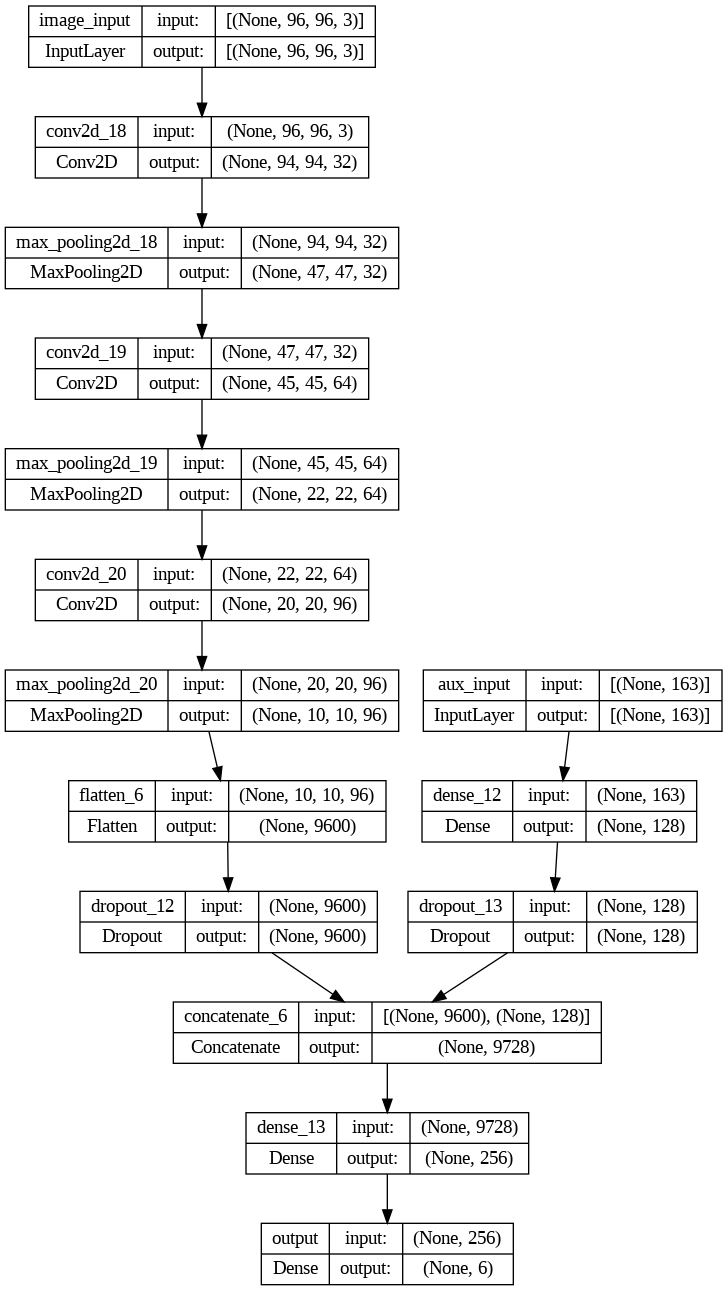

In [42]:
tf.keras.utils.plot_model(model, show_shapes=True)

### Fit the model
Before we can fit the model, we have to combine the image data generator output with the auxilliary tabular data.

In [55]:
BATCH_SIZE = 64
IMAGE_SIZE = (96,96)
train_datagen = ImageDataGenerator(rescale=1.0/255)
validation_datagen = ImageDataGenerator(rescale=1.0/255)

def create_generator(image_datagen, dataframe, batch_size):
    images_gen = image_datagen.flow_from_dataframe(
                 dataframe = dataframe,
                 directory = train_path,
                 x_col = 'image_id',
                 y_col = aux_cols,
                 batch_size = batch_size,
                 shuffle = False,
                 target_size = IMAGE_SIZE,
                 seed = 1,
                 class_mode = 'raw',)

    while True:
        list_df = [dataframe[i:i+batch_size] for i in range(0,dataframe.shape[0],batch_size)]
        for batch in list_df:
            batch_indices = batch.index
            # Get the target labels
            targets = dataframe.loc[batch_indices, class_names].values.reshape(-1,num_classes)
            images = next(images_gen)
            yield images,tf.convert_to_tensor(targets, dtype=tf.float32)



# Create the generator
train_generator = create_generator(train_datagen, train_df, BATCH_SIZE)
valid_generator = create_generator(validation_datagen, valid_df, BATCH_SIZE)


In [56]:
history = model.fit(train_generator,
                    steps_per_epoch=np.ceil(len(train_df)/BATCH_SIZE),
                    validation_data=valid_generator,
                    validation_steps=np.ceil(len(valid_df)/BATCH_SIZE),
                    epochs=5,
                    batch_size=BATCH_SIZE,
                    )

Found 39306 validated image filenames.
Epoch 1/5
615/615 [==============================] - 96s 153ms/step - loss: 63.8282 - cosine_similarity: 0.6777 - val_loss: 58.7269 - val_cosine_similarity: 0.7027
Epoch 2/5
615/615 [==============================] - 95s 155ms/step - loss: 58.6337 - cosine_similarity: 0.6978 - val_loss: 57.6761 - val_cosine_similarity: 0.7092
Epoch 3/5
615/615 [==============================] - 95s 154ms/step - loss: 57.3442 - cosine_similarity: 0.7015 - val_loss: 57.2451 - val_cosine_similarity: 0.7097
Epoch 4/5
615/615 [==============================] - 94s 153ms/step - loss: 56.5515 - cosine_similarity: 0.7039 - val_loss: 56.5847 - val_cosine_similarity: 0.7113
Epoch 5/5
615/615 [==============================] - 95s 154ms/step - loss: 55.8650 - cosine_similarity: 0.7044 - val_loss: 55.9674 - val_cosine_similarity: 0.7090


### Plot the model accuracy and loss by epoch

In [57]:
print(history.history.keys())

dict_keys(['loss', 'cosine_similarity', 'val_loss', 'val_cosine_similarity'])


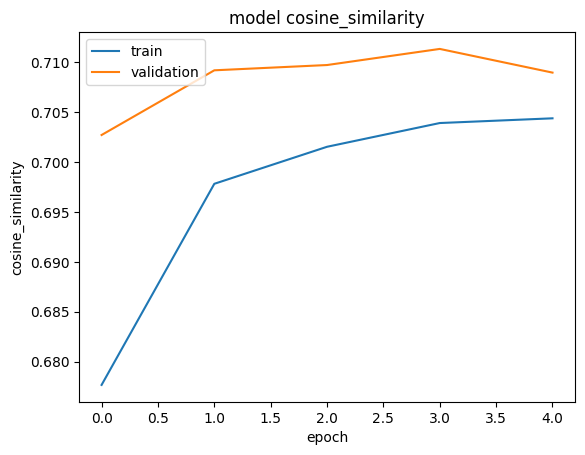

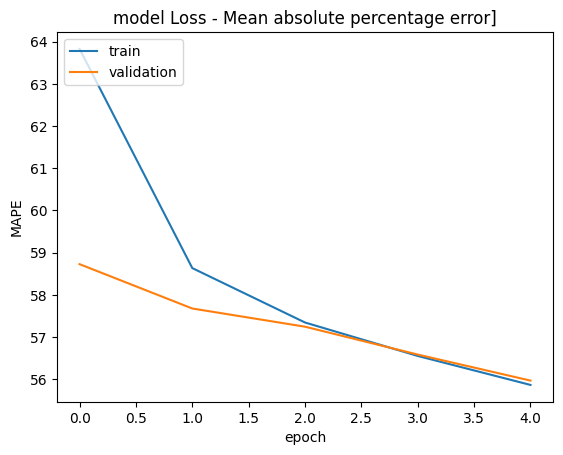

In [58]:

#  "cosine_similarity"
plt.plot(history.history['cosine_similarity'])
plt.plot(history.history['val_cosine_similarity'])
plt.title('model cosine_similarity')
plt.ylabel('cosine_similarity')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()
# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model Loss - Mean absolute percentage error]')
plt.ylabel('MAPE')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

**save the model for later use**

In [59]:
### Save the model
model.save("model_0621.keras")

In [60]:
!cp 'model_0621.keras' '/gdrive/MyDrive/kaggle/'
os.listdir('/gdrive/MyDrive/kaggle/')

['histopathologic-cancer-detection.zip',
 'nlp-getting-started.zip',
 'gan-getting-started.zip',
 'planttraits2024.zip',
 'kaggle.json',
 'week3_submission.csv',
 'week4_submission.csv',
 'learning-agency-lab-automated-essay-scoring-2.zip',
 'model2.keras',
 'model_8.keras',
 'model_9.keras',
 'model_final.keras',
 'model.keras',
 'submission.csv',
 'model_0619.keras',
 'model_0621.keras']

## Predict test output values
**Copy the model from google drive and load into memory**

Only need to run this cell if the notebook is run in two stages before and after creating the model

In [ ]:
#import os
#from google.colab import drive
#drive.mount('/gdrive')

gdrive_path = '/gdrive/MyDrive/kaggle/'
# Check current directory (be sure you're in the directory where Colab operates: '/content')
print(os.getcwd())
# Copy the .zip file into the present directory
full_path = gdrive_path+'model.keras'
!cp '{full_path}' .

model = tf.keras.models.load_model('model.keras')
model.summary()

/content
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 conv2d_9 (Conv2D)           (None, 94, 94, 32)           896       ['image_input[0][0]']         
                                                                                                  
 max_pooling2d_9 (MaxPoolin  (None, 47, 47, 32)           0         ['conv2d_9[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_10 (Conv2D)          (None, 45, 45, 64)           18496     ['max_pooling2d

**Read the `test.csv` file and normalize the auxilliary data fields**

In [61]:
df_test = pd.read_csv('./test.csv')
#df_test.set_index('id',drop=True,inplace=True)
df_test['image_id'] = df_test.id.astype(str) + '.jpeg'

x_cols = df_test.drop(columns=['id', 'image_id']).columns.tolist()
df_test[x_cols] = df_test[x_cols].fillna(0)
df_test[x_cols] = df_test[x_cols].apply(lambda x: (x - x.mean()) / (x.std()))
df_test.set_index('id',drop=True,inplace=True)
df_test.head()


WORLDCLIM_BIO1_annual_mean_temperature  \
id                                                  
201238668                               -0.750977   
202310319                               -0.373016   
202604412                               -0.748400   
201353439                               -0.889286   
195351745                               -1.202770   

           WORLDCLIM_BIO12_annual_precipitation  \
id                                                
201238668                              1.584028   
202310319                             -0.749869   
202604412                             -0.906574   
201353439                             -0.239376   
195351745                              1.654508   

           WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month  \
id                                                                                 
201238668                                                               0.009998   
202310319                                                              -0.703292   
202604412                                                              -0.617776   
201353439                                                              -0.398684   
195351745                                                               0.174343   

           WORLDCLIM_BIO15_precipitation_seasonality  \
id                                                     
201238668                                  -1.017968   
202310319                                  -1.072923   
202604412                                  -0.318045   
201353439                                  -0.475900   
195351745                                  -0.896876   

           WORLDCLIM_BIO4_temperature_seasonality  \
id                                                  
201238668                               -0.637688   
202310319                                0.824331   
202604412                                0.606691   
201353439                                0.428883   
195351745                               -0.268088   

           WORLDCLIM_BIO7_temperature_annual_range  \
id                                                   
201238668                                -0.941486   
202310319                                 0.454134   
202604412                                 1.114242   
201353439                                -0.037639   
195351745                                -0.350227   

           SOIL_bdod_0.5cm_mean_0.01_deg  SOIL_bdod_100.200cm_mean_0.01_deg  \
id                                                                            
201238668                      -1.926361                          -2.073699   
202310319                       0.776326                           0.906973   
202604412                       0.938487                          -0.453769   
201353439                      -0.683125                          -0.064985   
195351745                      -1.656093                          -1.749713   

           SOIL_bdod_15.30cm_mean_0.01_deg  SOIL_bdod_30.60cm_mean_0.01_deg  \
id                                                                            
201238668                        -2.267567                        -2.424582   
202310319                         0.843024                         0.653397   
202604412                         0.663567                        -0.085318   
201353439                        -0.712272                        -0.393116   
195351745                        -1.789015                        -1.685867   

           ...  VOD_X_1997_2018_multiyear_mean_m04  \
id         ...                                       
201238668  ...                            0.021618   
202310319  ...                           -0.696356   
202604412  ...                            0.256900   
201353439  ...                           -0.592253   
195351745  ...                            0.973229   

           VOD_X_1997_2018_multiyear_mean_m05  \
id          

In [62]:
df_test.shape

(6545, 164)

**Read the label metadata file**

In [ ]:
label_names = pd.read_table('./target_name_meta.tsv')
pd.set_option('display.max_colwidth', None)
label_names

trait_ID  \
0       X4   
1      X11   
2      X18   
3      X26   
4      X50   
5    X3112   

                                                                           trait_name   
0   Stem specific density (SSD) or wood density (stem dry mass per stem fresh volume)   
1                      Leaf area per leaf dry mass (specific leaf area, SLA or 1/LMA)   
2                                                                        Plant height   
3                                                                       Seed dry mass   
4                                             Leaf nitrogen (N) content per leaf area   
5  Leaf area (in case of compound leaves: leaf, undefined if petiole in- or excluded)

**Generate the test image data and combine with auxilliary data**

In [63]:
test_path = './test_images'
BATCH_SIZE = 64
IMAGE_SIZE = (96,96)

test_datagen = ImageDataGenerator(rescale=1./255)

def create_test_generator(image_datagen, dataframe, batch_size):
    images_gen = image_datagen.flow_from_dataframe(
                 dataframe = dataframe,
                 directory = test_path,
                 x_col = 'image_id',
                 y_col = aux_cols,
                 batch_size = batch_size,
                 shuffle = False,
                 target_size = IMAGE_SIZE,
                 seed = 1,
                 class_mode = 'raw',)

    while True:
        list_df = [dataframe[i:i+batch_size] for i in range(0,dataframe.shape[0],batch_size)]
        for batch in list_df:
            batch_indices = batch.index
            # Get the target labels
            targets = dataframe.loc[batch_indices, aux_cols].values
            images = next(images_gen)
            yield images, tf.convert_to_tensor(targets, dtype=tf.float32)

# Create the generator
test_generator = create_test_generator(test_datagen, df_test, BATCH_SIZE)


In [70]:
test_results = model.predict(test_generator,steps=np.ceil(len(df_test)/BATCH_SIZE))
print(test_results.shape)


103/103 [==============================] - 14s 134ms/step
(6545, 6)


In [72]:
test_ds = pd.DataFrame(test_results, columns=label_names.trait_ID)
test_ds['id'] = df_test.index


**De-normalize the predicted results data**

In order to do that we first store the mean and std values of the label columns (_mean) from the train dataset. We will use it for de-normalizing the results

In [73]:
#train = pd.read_csv('./train.csv')

#class_names = list(label_names.trait_ID.astype(str)+'_mean')
#print(class_names)
print(test_ds.columns.tolist())
train_mean = {}
train_std = {}
for col in class_names:
    train_mean[col] = train[col].mean()
    train_std[col] = train[col].std()

for label in label_names.trait_ID:
    dict_label = label + '_mean'
    test_ds[label] = test_ds[label] * train_std[dict_label] + train_mean[dict_label]

##Re-arrange the columns in the test output
test_labels = ['id','X4','X11','X18','X50','X26','X3112']
test_ds = test_ds[test_labels]
print(test_ds.shape)
test_ds.head()

['X4', 'X11', 'X18', 'X26', 'X50', 'X3112', 'id']
(6545, 7)


trait_ID         id        X4         X11       X18       X50        X26  \
0         201238668  0.573549  104.276932  4.206088  2.298880  43.381199   
1         202310319  0.594851   82.772186  4.529515  2.482261  48.063324   
2         202604412  0.582405   91.692902  4.904883  2.428840  43.215412   
3         201353439  0.572800  123.193939  3.619967  2.380390  38.165112   
4         195351745  0.599726   70.032906  5.060077  2.548385  46.200459   

trait_ID         X3112  
0         58263.910156  
1         48129.691406  
2         52821.156250  
3         68332.632812  
4         41568.929688

#### Check the model accuracy against the sample submission dataset
We will read the sample submission file and evaluate the output against the sample results given

**Check the sample submission file**

In [ ]:
df_samples = pd.read_csv('./sample_submission.csv')
#test_data = df_samples.astype(str)
#test_data = test_data.sample(1000)
#test_data['id'] += '.tif'
df_samples.head()

id         X4        X11        X18        X50        X26      X3112
0  201238668  21.228750  46.704747  31.430122  14.088638  24.208952  93.351051
1  202310319   4.938497  71.644437  50.208404  99.503446  86.561125  20.325735
2  202604412  34.268159  93.046483  74.556941  84.275746  85.713291  23.470287
3  201353439  48.213879  84.687775  -1.442158  -9.852137  13.327949  -0.274766
4  195351745  55.117501  87.046172  84.335483  79.218376  19.142174  11.294033

#### Copy the predicted values into output file for submission

In [74]:
pd.isnull(test_ds).sum()

trait_ID
id       0
X4       0
X11      0
X18      0
X50      0
X26      0
X3112    0
dtype: int64

In [75]:
test_ds.shape

(6545, 7)

In [76]:
test_ds.to_csv('submission.csv', index=False)
!cp submission.csv '/gdrive/MyDrive/kaggle/'

In [77]:
# Import OS for navigation and environment set up
import os
# Check current location, '/content' is the Colab virtual machine
os.getcwd()
# Enable the Kaggle environment, use the path to the directory your Kaggle API JSON is stored in
os.environ['KAGGLE_CONFIG_DIR'] = '/gdrive/MyDrive/kaggle'

In [78]:
# Navigate into Drive where you want to store your Kaggle data
os.chdir('/gdrive/MyDrive/kaggle')
# Paste and run the copied API command, the data will download to the current directory
#!kaggle datasets download -d histopathologic-cancer-detection
# Check contents of directory, you should see the .zip file for the competition in your Drive
os.listdir()

['histopathologic-cancer-detection.zip',
 'nlp-getting-started.zip',
 'gan-getting-started.zip',
 'planttraits2024.zip',
 'kaggle.json',
 'week3_submission.csv',
 'week4_submission.csv',
 'learning-agency-lab-automated-essay-scoring-2.zip',
 'model2.keras',
 'model_8.keras',
 'model_9.keras',
 'model_final.keras',
 'model.keras',
 'submission.csv',
 'model_0619.keras',
 'model_0621.keras']

In [79]:
!kaggle competitions submit -c planttraits2024 -f submission.csv -m "DTSA-5511 Final Project Kaggle Plant Traits"

100% 437k/437k [00:00<00:00, 458kB/s]
Successfully submitted to PlantTraits2024 - FGVC11